In [68]:
# Modules
from sklearn.experimental import enable_iterative_imputer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from typing import Literal
import impyute as impy
import seaborn as sns

np.random.seed(42)
plt.rc('figure', figsize=(12, 3))

# Plan
1. Generating simple univariate TS
2. Inducing MCAR missing values
3. Evaluation metrics


# To DO
- Add distribution tests
- Add ARIMA Model
- Implement Encoder

## 1. Generate Simple Univariate Time Series

In [39]:
# Function to generate time serie
def generate_time_serie(start: int, end:int , n : int, with_noise: bool = False, is_sinus:bool = False,noise_type: Literal["random","normal"] = "normal",
    a: float = 2, b: float = 3, mean: float = 0, std: float = 1, start_date : str = '1/1/2022', freq = 'H') -> pd.DataFrame:
    steps = np.linspace(start, end, n)
    ## The function 
    if is_sinus:
        y = np.sin(steps)
    else:
        y = a*steps + b
    try:
        ## The noise
        if with_noise:
            if noise_type == "random":
                y = y + np.random.random(n)
            elif noise_type == "normal":
                y = y + np.random.normal(mean, std, n)
            else:
                raise ValueError("Error : The noise type '{}' is not supported".format(noise_type))
        df = pd.DataFrame(y , columns = ['records'])
        df.index = pd.date_range(start = start_date, periods=n, freq = freq)
        return df
    except ValueError as e:
        raise(e)

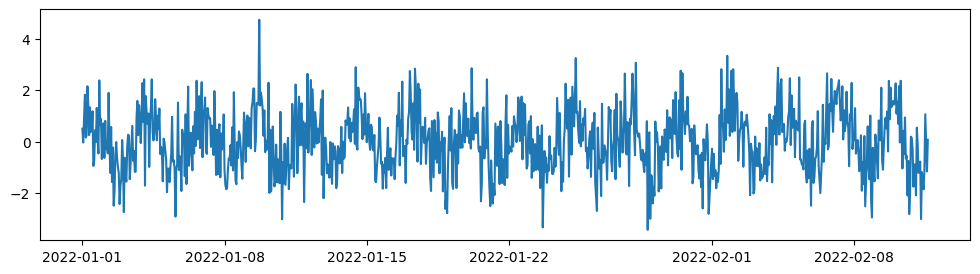

In [40]:
df = generate_time_serie(0, 100, 1000, with_noise=True, is_sinus=True, noise_type="normal", start_date='1/1/2022', freq='H')
plt.plot(df)

## Induce Missing Values

In [42]:
# Generate missing values and the mask
def generate_MCAR_nans(df: pd.DataFrame, missing_rate:float) -> tuple[pd.DataFrame, np.ndarray]:
    df_nan = df.mask(np.random.random(df.shape) < missing_rate,inplace=False)
    mask = (~np.isnan(df.values)).astype('uint8')
    return df_nan, mask

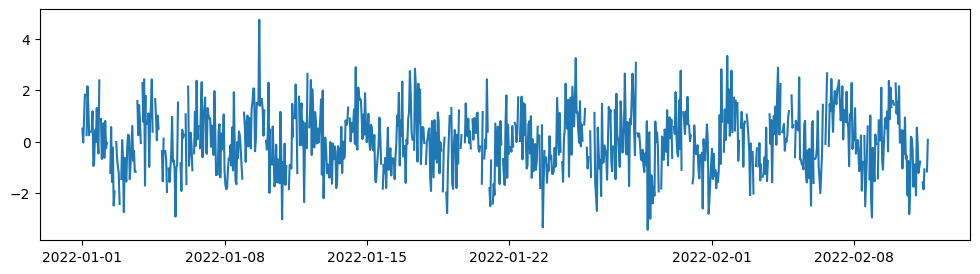

In [46]:
df_nan, mask = generate_MCAR_nans(df, 0.1)
plt.plot(df_nan)

## Imputations Methods Evaluation

In [47]:
# Evaluate imputation using MSE AND MAE
def evaluate_imputation_mse(df: pd.DataFrame, df_imputed: pd.DataFrame, method_title: str) -> pd.DataFrame:
    mse = mean_squared_error(df.values, df_imputed, squared=True)
    mae = mean_absolute_error(df.values, df_imputed)
    result = pd.DataFrame({'method':method_title,'mse':mse, 'mae':mae}, index=[0])
    return result

In [ ]:
# Comparaison of distribution before and after imputation with static tests
# def compare_distribution(df: pd.DataFrame, df_imputed: pd.DataFrame, method_title: str) -> pd.DataFrame:
    

## Classical Imputers

In [48]:
def simple_impute(df: pd.DataFrame,strategy: 
    Literal['mean','median','mode','LOCF','NOCB','linear_interpolation','polynomial_interpolation','spline_interpolation'],order = 3) -> pd.DataFrame:
    try:
        df = df.copy()
        df_imputed = None
        if strategy == 'mean':
            mean_imp = SimpleImputer(strategy='mean')
            df_imputed = pd.DataFrame(mean_imp.fit_transform(df),columns=df.columns)
        elif strategy == 'median':
            median_imp = SimpleImputer(strategy='median')
            df_imputed = pd.DataFrame(median_imp.fit_transform(df),columns=df.columns)
        elif strategy == 'mode':
            most_frequent_imp = SimpleImputer(strategy='most_frequent')
            df_imputed =  pd.DataFrame(most_frequent_imp.fit_transform(df), columns=df.columns)
        elif strategy == 'LOCF':
            df_imputed = df.fillna(method='ffill').fillna(method='bfill')
        elif strategy == 'NOCB':
            df_imputed = df.fillna(method='bfill').fillna(method='ffill')
        elif strategy == 'linear_interpolation':
            df_imputed = df.interpolate(method='linear',limit_direction='both')
        elif strategy == 'polynomial_interpolation':
            df_imputed = df.interpolate(method='polynomial',order=order,limit_direction='both')
        elif strategy == 'spline_interpolation':
            df_imputed = df.interpolate(method='spline',order=order,limit_direction='both')
        else:
            raise ValueError("Error : The strategy '{}' is not supported".format(strategy))
        return df_imputed
    except ValueError as e:
        raise(e)

In [55]:
class_methods = ['mean','median','mode','LOCF','NOCB','linear_interpolation','polynomial_interpolation','spline_interpolation']

def evaluate_set(list_methods,df_origin, df_with_nan):
    evals = pd.DataFrame()
    for strat in list_methods:
        df_imputed = simple_impute(df_with_nan,strat)
        evals = pd.concat([evals,evaluate_imputation_mse(df_origin,df_imputed, strat)])
    evals.sort_values(by=["mse"], inplace = True)
    evals.reset_index(drop=True, inplace=True)
    return evals


In [60]:
evaluations = evaluate_set(class_methods,df,df_nan)
evaluations

,method,mse,mae
0,spline_interpolation,0.102923,0.083066
1,linear_interpolation,0.130227,0.094222
2,NOCB,0.148373,0.100595
3,mean,0.156647,0.100716
4,median,0.156932,0.100656
5,LOCF,0.209656,0.119191
6,polynomial_interpolation,0.234171,0.125956
7,mode,1.390952,0.354837


<AxesSubplot: xlabel='mse', ylabel='method'>

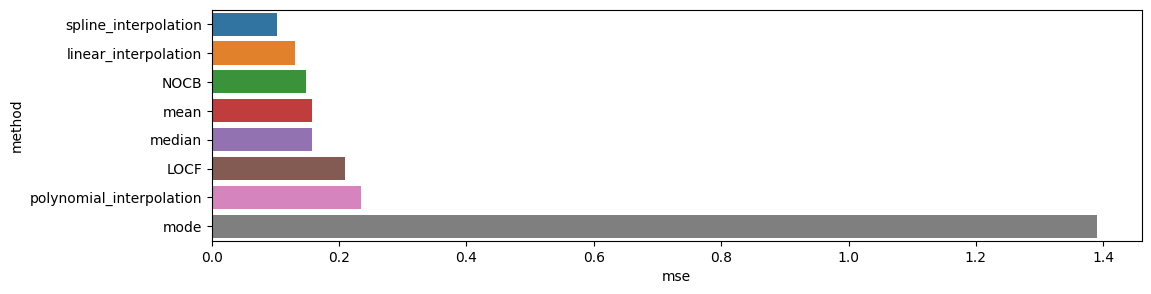

In [63]:
evaluations = evaluate_set(class_methods,df,df_nan)
sns.barplot(x="mse", y="method", data=evaluations)

<AxesSubplot: xlabel='mae', ylabel='method'>

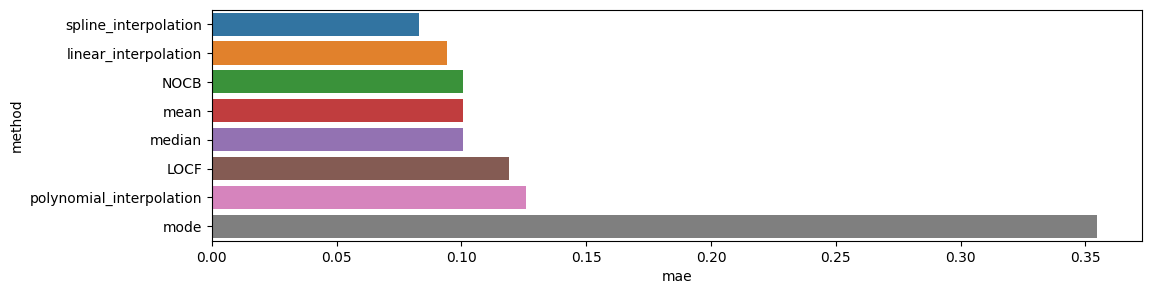

In [66]:
sns.barplot(x="mae", y="method", data=evaluations)

# ML based imputers

In [70]:
def ml_impute(df: pd.DataFrame, model_name: Literal['knn','mice']):
    try:
        df = df.copy()
        df_imputed = None
        if model_name == 'knn':
            knn_imp = KNNImputer()
            df_imputed = pd.DataFrame(knn_imp.fit_transform(df),columns=df.columns)
        elif model_name == 'mice':
            mice_imp = IterativeImputer()
            df_imputed = pd.DataFrame(mice_imp.fit_transform(df),columns=df.columns)
        else:
            raise ValueError("Error : The model '{}' is not supported".format(model_name))
        return df_imputed
    except ValueError as e:
        raise(e)

In [72]:
ml_methods = ['knn','mice']
def evaluate_set_ML(ml_methods,df_origin, df_with_nan):
    evals = pd.DataFrame()
    for strat in ml_methods:
        df_imputed = ml_impute(df_with_nan,strat)
        evals = pd.concat([evals,evaluate_imputation_mse(df_origin,df_imputed, strat)])
    evals.sort_values(by=["mse"], inplace = True)
    evals.reset_index(drop=True, inplace=True)
    return evals

evaluations = evaluate_set_ML(ml_methods,df,df_nan)

In [75]:
evaluations

,method,mse,mae
0,knn,0.156647,0.100716
1,mice,0.156647,0.100716


<AxesSubplot: xlabel='mse', ylabel='method'>

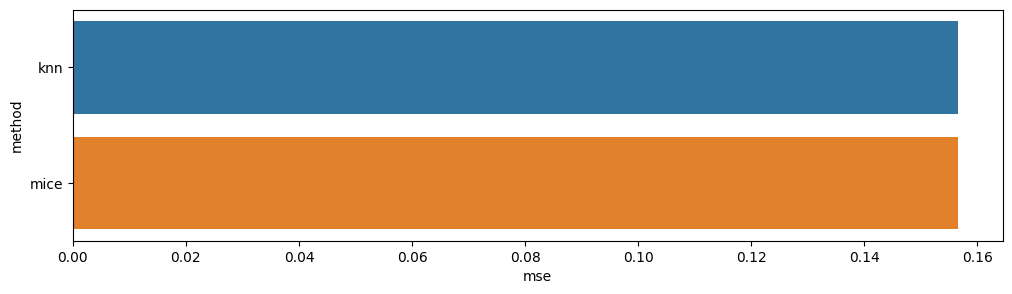

In [74]:
sns.barplot(x="mse", y="method", data=evaluations)

<AxesSubplot: xlabel='mae', ylabel='method'>

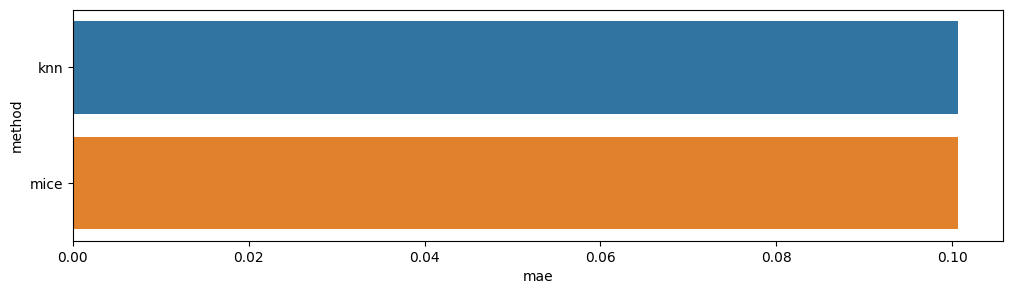

In [73]:
sns.barplot(x="mae", y="method", data=evaluations)